# Corpus Analysis
In this notebook we analyze the chunked corpus (storage/chunks/chunks.jsonl)

## 1 Setup and configuration

In [14]:
import json
import re
import math
import random
import statistics
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

random.seed(55)
np.random.seed(55)

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

ROOT = Path.cwd()
ARTIFACTS_DIR = ROOT / "artifacts" / "corpus_analysis"
TABLES_DIR = ARTIFACTS_DIR / "tables"
PLOTS_DIR = ARTIFACTS_DIR / "plots"
TABLES_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)


def find_chunks_path():
    candidates = [
        ROOT / "storage" / "chunks" / "chunks.jsonl",
        Path("storage") / "chunks" / "chunks.jsonl",
    ]
    for path in candidates:
        if path.exists():
            return path
    storage_dir = ROOT / "storage"
    if storage_dir.exists():
        matches = list(storage_dir.rglob("chunks.jsonl"))
        if matches:
            return matches[0]
    raise FileNotFoundError(
        "chunks.jsonl not found. Run: python scripts/build_index.py --rebuild"
    )


CHUNKS_PATH = find_chunks_path()
CHUNKS_PATH

WindowsPath('c:/PythonProjects/RAG-BOT/storage/chunks/chunks.jsonl')

## 2 Load chunks

In [15]:
rows = []

with CHUNKS_PATH.open("r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        obj = json.loads(line)
        meta = obj.get("metadata") or {}
        text = obj.get("text")
        if text is None:
            text = obj.get("chunk_text", "")
        row = {
            "doc_id": meta.get("doc_id") or obj.get("doc_id") or "",
            "text": text if text is not None else "",
            "tags": meta.get("tags") or obj.get("tags") or "",
            "title": meta.get("title") or obj.get("title") or "",
            "local_path": meta.get("local_path") or obj.get("local_path") or "",
            "source_type": meta.get("doc_type") or meta.get("source_type") or obj.get("doc_type") or obj.get("source_type") or "",
        }
        rows.append(row)

df = pd.DataFrame(rows)
for col in ["doc_id", "text", "tags", "title", "local_path", "source_type"]:
    if col not in df.columns:
        df[col] = ""

if not df.empty:
    df["text"] = df["text"].astype(str).str.rstrip()

print(f"Loaded chunks: {len(df)}")
df.head()


Loaded chunks: 319


,doc_id,text,tags,title,local_path,source_type
0,rag_corpus_cargo_customs_clearance_txt,Customs clearance\nWe provide services:\n•prep...,cargo,Cargo Customs Clearance,RAG-corpus/cargo-customs-clearance.txt,txt
1,rag_corpus_cargo_customs_clearance_txt,Types of containers used for transporting furn...,cargo,Cargo Customs Clearance,RAG-corpus/cargo-customs-clearance.txt,txt
2,rag_corpus_cargo_forwarding_txt,Forwarding services\nOur company will take on ...,cargo,Cargo Forwarding,RAG-corpus/cargo-forwarding.txt,txt
3,rag_corpus_cargo_forwarding_txt,Thanks to well-established connections with th...,cargo,Cargo Forwarding,RAG-corpus/cargo-forwarding.txt,txt
4,rag_corpus_cargo_product_certification_txt,Product certification\nProduct certification m...,cargo,Cargo Product Certification,RAG-corpus/cargo-product-certification.txt,txt


## 3 Load manifest

In [16]:
manifest_path = ROOT / "manifest.json"
manifest_csv_path = ROOT / "manifest.csv"
manifest_df = None

if manifest_path.exists():
    manifest_df = pd.read_json(manifest_path)
elif manifest_csv_path.exists():
    manifest_df = pd.read_csv(manifest_csv_path)

if manifest_df is not None:
    manifest_df = manifest_df.fillna("")
    keep_cols = ["doc_id", "title", "local_path", "doc_type", "tags"]
    for col in keep_cols:
        if col not in manifest_df.columns:
            manifest_df[col] = ""
    df = df.merge(manifest_df[keep_cols], on="doc_id", how="left", suffixes=("", "_manifest"))

    def _fill_from_manifest(col):
        manifest_col = f"{col}_manifest"
        if manifest_col in df.columns:
            df[col] = df[col].where(df[col].astype(str).str.len() > 0, df[manifest_col])

    for col in ["title", "local_path", "tags"]:
        _fill_from_manifest(col)
    if "doc_type_manifest" in df.columns:
        df["source_type"] = df["source_type"].where(df["source_type"].astype(str).str.len() > 0, df["doc_type_manifest"])

    drop_cols = [c for c in df.columns if c.endswith("_manifest")]
    df.drop(columns=drop_cols, inplace=True, errors="ignore")

manifest_df is not None


True

## 4 Basic corpus overview

In [17]:
def _word_count(text):
    return len(re.findall(r"\b\w+\b", text))

if not df.empty:
    df["char_len"] = df["text"].str.len()
    df["word_len"] = df["text"].apply(_word_count)

    total_chunks = int(len(df))
    total_chars = int(df["char_len"].sum())
    total_words = int(df["word_len"].sum())
    unique_docs = int(df["doc_id"].nunique())

    overview = pd.DataFrame([
        {
            "total_chunks": total_chunks,
            "total_chars": total_chars,
            "total_words": total_words,
            "unique_doc_ids": unique_docs,
        }
    ])
    overview.to_csv(TABLES_DIR / "overview_totals.csv", index=False)
    display(overview)

    doc_counts = df.groupby("doc_id").size().sort_values(ascending=False)

    top_docs = doc_counts.head(20).to_frame("chunk_count")
    top_docs.to_csv(TABLES_DIR / "top_docs_by_chunk_count.csv")
    display(top_docs)

    def _parse_tags(val):
        if isinstance(val, list):
            tags = [str(v).strip().lower() for v in val if str(v).strip()]
        else:
            tags = [t.strip().lower() for t in str(val).split(",") if t.strip()]
        return tags

    df["tag_list"] = df["tags"].apply(_parse_tags)
    tag_df = df.explode("tag_list")
    tag_df = tag_df[tag_df["tag_list"].astype(str).str.len() > 0]
    if not tag_df.empty:
        tag_counts = tag_df["tag_list"].value_counts()
        top_tags = tag_counts.head(20).to_frame("chunk_count")
        top_tags["percent_total"] = (top_tags["chunk_count"] / total_chunks * 100).round(2)
        top_tags.to_csv(TABLES_DIR / "top_tags_by_chunk_count.csv")
        display(top_tags)
    else:
        tag_counts = pd.Series(dtype=int)



,total_chunks,total_chars,total_words,unique_doc_ids
0,319,102659,15434,29


,chunk_count
doc_id,
rag_corpus_form_china_csv,32
rag_corpus_furniture_tour_cost_duties_csv,27
rag_corpus_form_japan_csv,25
rag_corpus_furniture_tour_delivery_weights_csv,24
rag_corpus_form_taiwan_csv,21
rag_corpus_visas_categories_table_csv,16
rag_corpus_visas_taiwan_csv,16
rag_corpus_visas_china_csv,16
rag_corpus_personal_data_consent_txt,13


,chunk_count,percent_total
tag_list,,
china,217,68.03
furniture,114,35.74
form,78,24.45
visa,70,21.94
cargo,42,13.17
prices,40,12.54
taiwan,37,11.60
japan,35,10.97
duties,27,8.46


## 5 Chunk length analysis

,count,mean,std,min,10%,25%,50%,75%,90%,max
char_len,319.0,321.815047,356.359317,14.0,104.0,141.0,176.0,279.5,892.6,1560.0
word_len,319.0,48.382445,59.155252,2.0,11.8,17.0,24.0,41.5,150.0,252.0
sentence_count,319.0,3.783699,3.873014,1.0,1.0,2.0,3.0,4.0,7.0,33.0


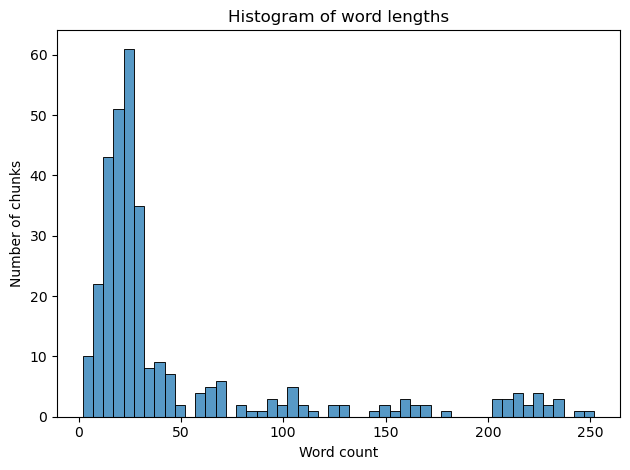

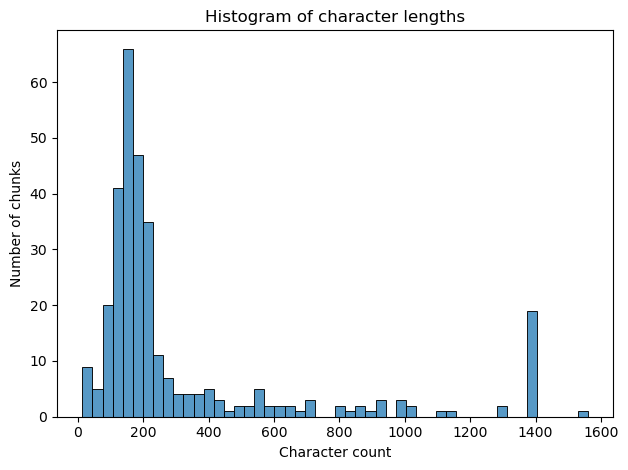

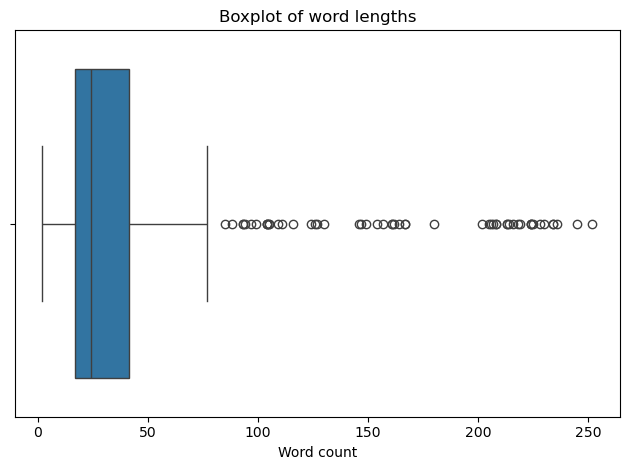

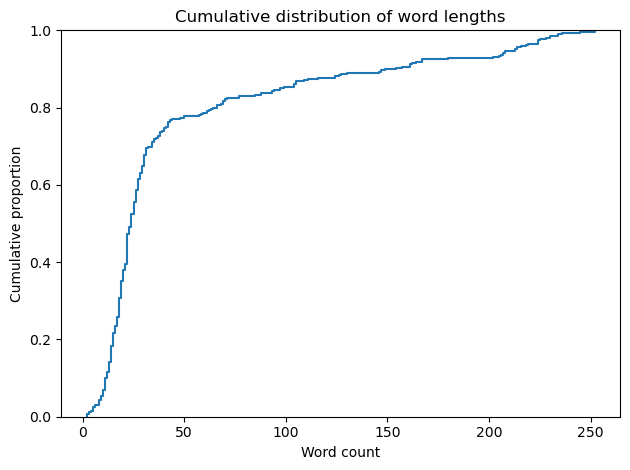

In [18]:
if not df.empty:
    sentence_split = re.compile(r"[.!?]+")
    df["sentence_count"] = df["text"].apply(lambda t: len([s for s in sentence_split.split(t) if s.strip()]))

    stats = df[["char_len", "word_len", "sentence_count"]].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]).T
    for row in ["mean", "std", "90%"]:
        if row in stats.index:
            stats.loc[row] = stats.loc[row].round(2)
    stats.to_csv(TABLES_DIR / "chunk_length_stats.csv")
    display(stats)

    plt.figure()
    sns.histplot(df["word_len"], bins=50)
    plt.title("Histogram of word lengths")
    plt.xlabel("Word count")
    plt.ylabel("Number of chunks")
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / "hist_word_len.png")
    plt.show()

    plt.figure()
    sns.histplot(df["char_len"], bins=50)
    plt.title("Histogram of character lengths")
    plt.xlabel("Character count")
    plt.ylabel("Number of chunks")
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / "hist_char_len.png")
    plt.show()

    plt.figure()
    sns.boxplot(x=df["word_len"])
    plt.title("Boxplot of word lengths")
    plt.xlabel("Word count")
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / "boxplot_word_len.png")
    plt.show()

    plt.figure()
    sns.ecdfplot(df["word_len"])
    plt.title("Cumulative distribution of word lengths")
    plt.xlabel("Word count")
    plt.ylabel("Cumulative proportion")
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / "ecdf_word_len.png")
    plt.show()


## 6 Coverage by domain and metadata

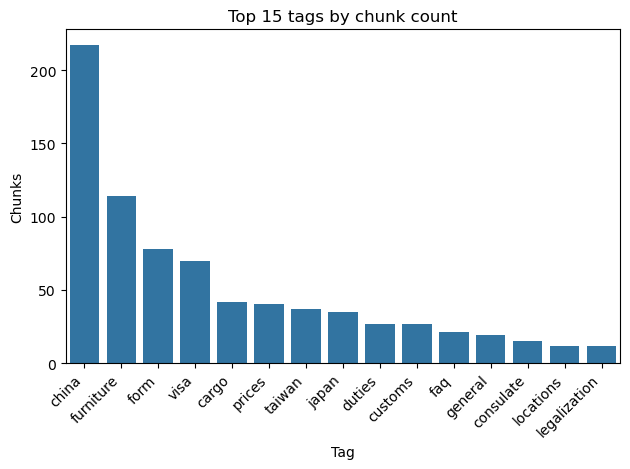

In [19]:
if "tag_list" in df.columns:
    tag_df = df.explode("tag_list")
    tag_df = tag_df[tag_df["tag_list"].astype(str).str.len() > 0]
    if not tag_df.empty:
        tag_counts = tag_df["tag_list"].value_counts()
        top_tags = tag_counts.head(15)
        plt.figure()
        sns.barplot(x=top_tags.index, y=top_tags.values)
        plt.title("Top 15 tags by chunk count")
        plt.xlabel("Tag")
        plt.ylabel("Chunks")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.savefig(PLOTS_DIR / "top_tags_bar.png")
        plt.show()

    if not tag_df.empty and "country" in df.columns and df["country"].astype(str).str.len().any():
        tag_counts = tag_df["tag_list"].value_counts()
        top_tags = list(tag_counts.head(10).index)
        tag_country = tag_df[tag_df["tag_list"].isin(top_tags)].copy()
        country_series = tag_country["country"].astype(str).str.strip().replace("", "Unknown")
        top_countries = list(country_series.value_counts().head(5).index)
        tag_country["country_group"] = country_series.apply(lambda c: c if c in top_countries else "Other")
        plt.figure(figsize=(10, 6))
        sns.histplot(
            data=tag_country,
            x="tag_list",
            hue="country_group",
            multiple="stack",
            discrete=True,
        )
        plt.title("Top tags by country")
        plt.xlabel("Tag")
        plt.ylabel("Chunks")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.savefig(PLOTS_DIR / "top_tags_by_country_stacked.png")
        plt.show()


# 7 Fact density metrics

,signal,percent_chunks
0,has_number,60.50
1,has_currency,23.82
2,has_time,19.44
3,has_weight,16.30
4,has_phone_or_email,1.88
5,has_url,0.00


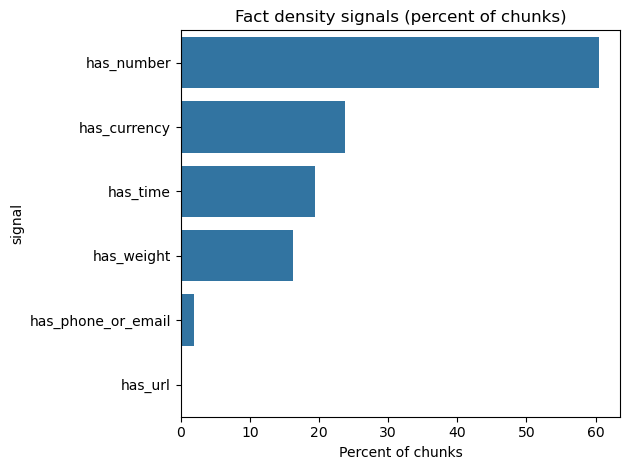

In [20]:
def _flag(pattern, text):
    return bool(re.search(pattern, text, flags=re.IGNORECASE))

if not df.empty:
    df["has_number"] = df["text"].apply(lambda t: _flag(r"\d", t))
    df["has_currency"] = df["text"].apply(lambda t: _flag(r"(rub|usd|eur|\$|\u20ac|\u20bd|\u0440\u0443\u0431)", t))
    df["has_time"] = df["text"].apply(lambda t: _flag(r"\b(day|days|week|weeks|month|months|urgent|express|working days?)\b", t))
    df["has_weight"] = df["text"].apply(lambda t: _flag(r"\bkg\b", t))
    df["has_phone_or_email"] = df["text"].apply(
        lambda t: _flag(r"[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}", t)
        or _flag(r"\+?\d[\d\-\s()]{7,}\d", t)
    )
    df["has_url"] = df["text"].apply(lambda t: _flag(r"(https?://|www\.)", t))

    signal_cols = [
        "has_number",
        "has_currency",
        "has_time",
        "has_weight",
        "has_phone_or_email",
        "has_url",
    ]
    signal_rows = []
    for col in signal_cols:
        pct = float(df[col].mean() * 100) if len(df) else 0.0
        signal_rows.append({"signal": col, "percent_chunks": round(pct, 2)})
    signal_df = pd.DataFrame(signal_rows)
    signal_df.to_csv(TABLES_DIR / "fact_density_signals.csv", index=False)
    display(signal_df)

    plt.figure()
    sns.barplot(data=signal_df, x="percent_chunks", y="signal")
    plt.title("Fact density signals (percent of chunks)")
    plt.xlabel("Percent of chunks")
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / "fact_density_signals.png")
    plt.show()


## 8 Keyword and n-gram snapshot

,token,count
0,field,438
1,furniture,253
2,label,219
3,notes,219
4,china,216
5,visa,153
6,data,114
7,personal,104
8,tour,99
9,form,85


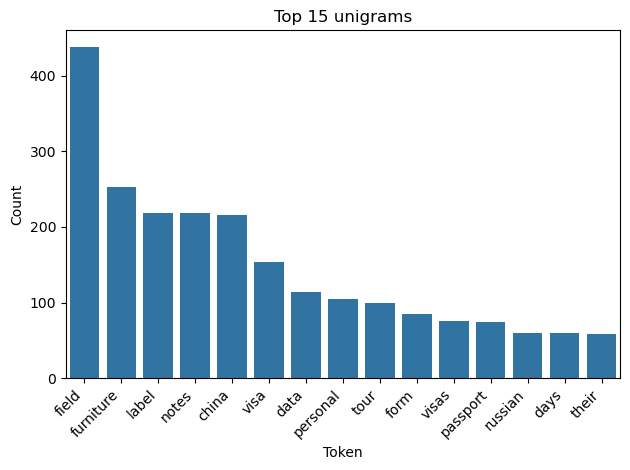

,bigram,count
5278,personal data,98
3168,furniture tour,89
3512,in china,56
1454,china field_label,48
4649,of furniture,40
6464,taiwan field_label,37
6849,tour cost,36
3877,japan field_label,35
7096,visa free,35
6019,russian federation,34


In [21]:
stopwords = {
    "the", "and", "for", "with", "that", "this", "from", "are", "was", "were",
    "you", "your", "our", "has", "have", "will", "can", "not", "but", "all",
    "any", "into", "about", "than", "such", "use", "using", "need", "info",
}

if not df.empty:
    tokens = []
    for text in df["text"]:
        for tok in re.findall(r"[A-Za-z\u0400-\u04FF]+", text.lower()):
            if len(tok) < 3:
                continue
            if tok in stopwords:
                continue
            tokens.append(tok)

    unigram_counts = Counter(tokens)
    top_unigrams = pd.DataFrame(unigram_counts.most_common(20), columns=["token", "count"])
    top_unigrams.to_csv(TABLES_DIR / "top_unigrams.csv", index=False)
    display(top_unigrams)

    plt.figure()
    top_plot = top_unigrams.head(15)
    sns.barplot(data=top_plot, x="token", y="count")
    plt.title("Top 15 unigrams")
    plt.xlabel("Token")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / "top_unigrams_bar.png")
    plt.show()

    try:
        from sklearn.feature_extraction.text import CountVectorizer

        vectorizer = CountVectorizer(
            ngram_range=(2, 2),
            stop_words=list(stopwords),
            token_pattern=r"(?u)\b\w+\b",
        )
        X = vectorizer.fit_transform(df["text"].fillna(""))
        counts = X.sum(axis=0).A1
        terms = vectorizer.get_feature_names_out()
        bigram_df = pd.DataFrame({"bigram": terms, "count": counts})
        bigram_df = bigram_df.sort_values("count", ascending=False).head(15)
        bigram_df.to_csv(TABLES_DIR / "top_bigrams.csv", index=False)
        display(bigram_df)
    except Exception as exc:
        print(f"Skipping bigrams (sklearn unavailable): {exc}")
